In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Not running in Colab, skipping Google Drive mount.")

Mounted at /content/drive


Finding suitable samples...
Real sample: sample_00964 (16 frames)
Fake sample: sample_01208 (16 frames)

✓ Generated ELA images

✓ Saved full comparison → /content/drive/MyDrive/FakeAVCeleb/poster_images/ela_comparison_full.png


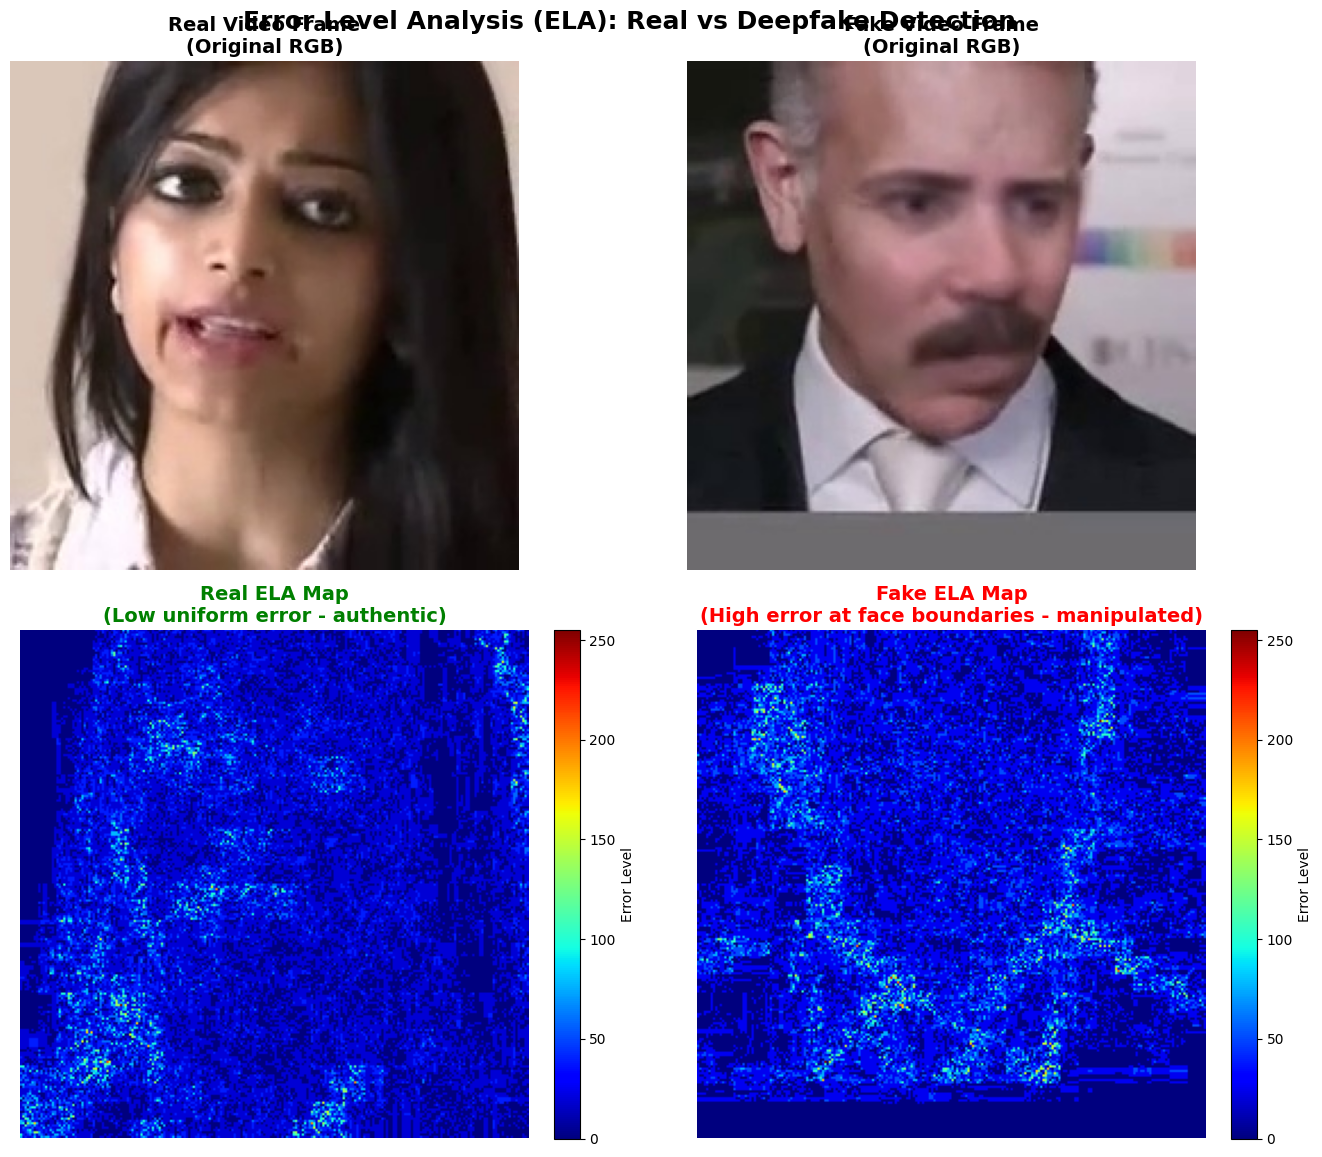

/tmp/ipython-input-2771134142.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved poster version → /content/drive/MyDrive/FakeAVCeleb/poster_images/ela_comparison_poster.png


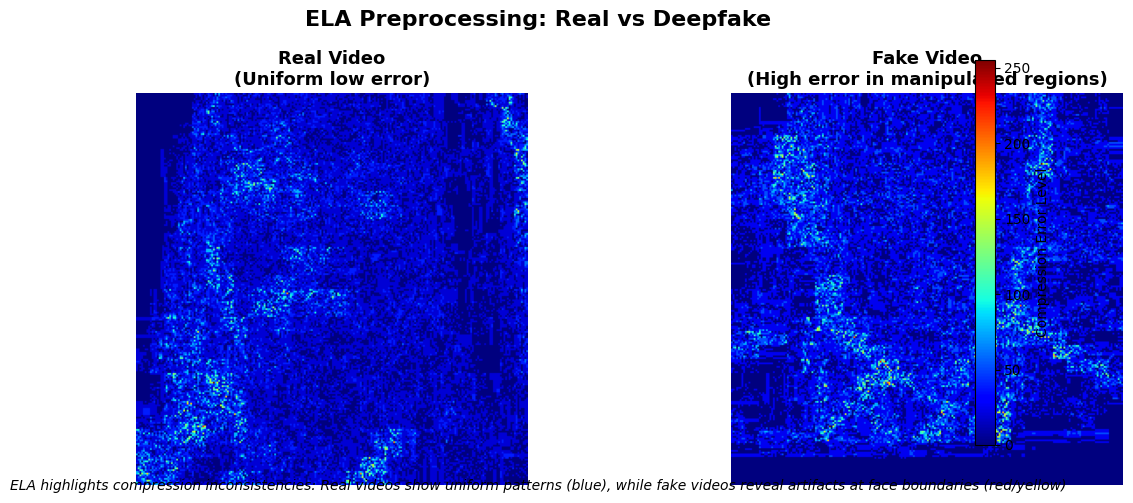

✓ Saved side-by-side → /content/drive/MyDrive/FakeAVCeleb/poster_images/ela_sidebyside.png


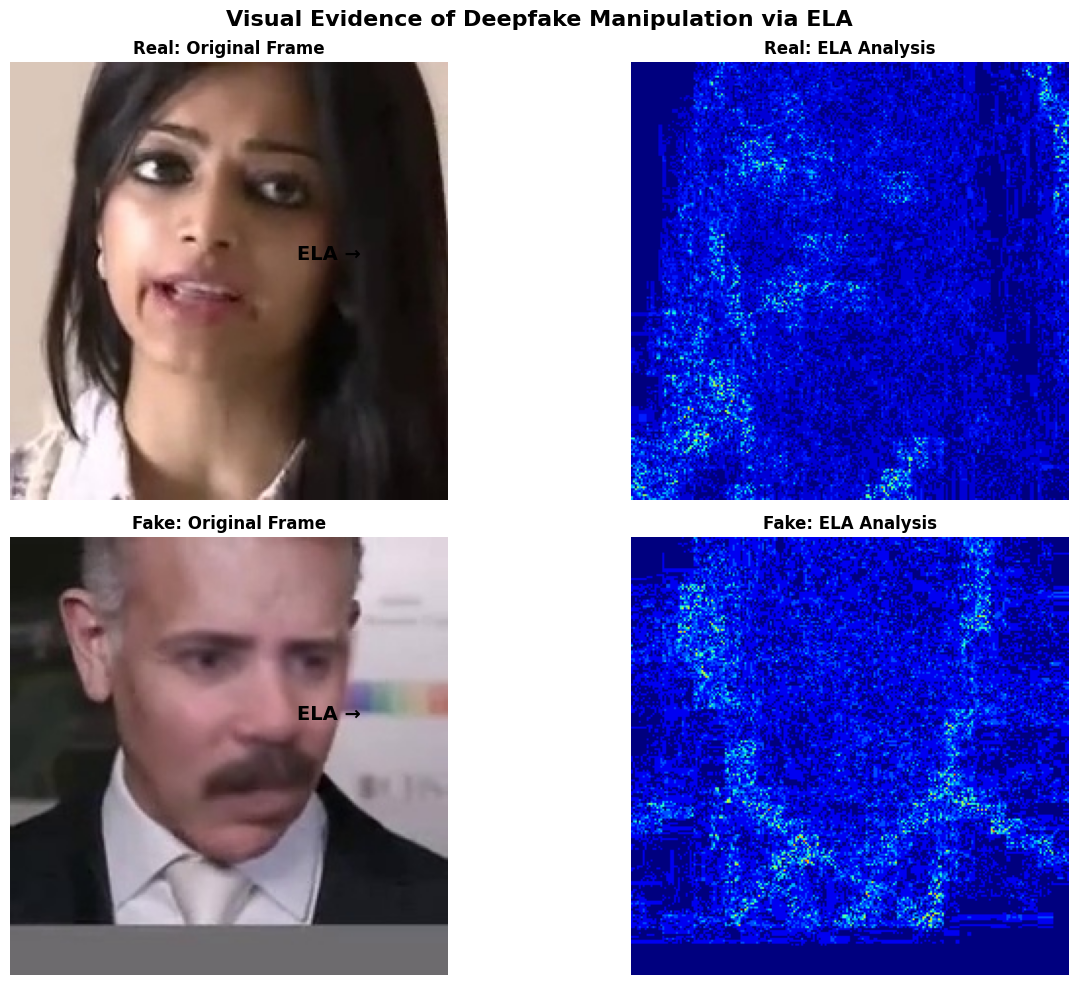


📊 Generating additional examples...
✓ Saved multiple examples → /content/drive/MyDrive/FakeAVCeleb/poster_images/ela_multiple_examples.png


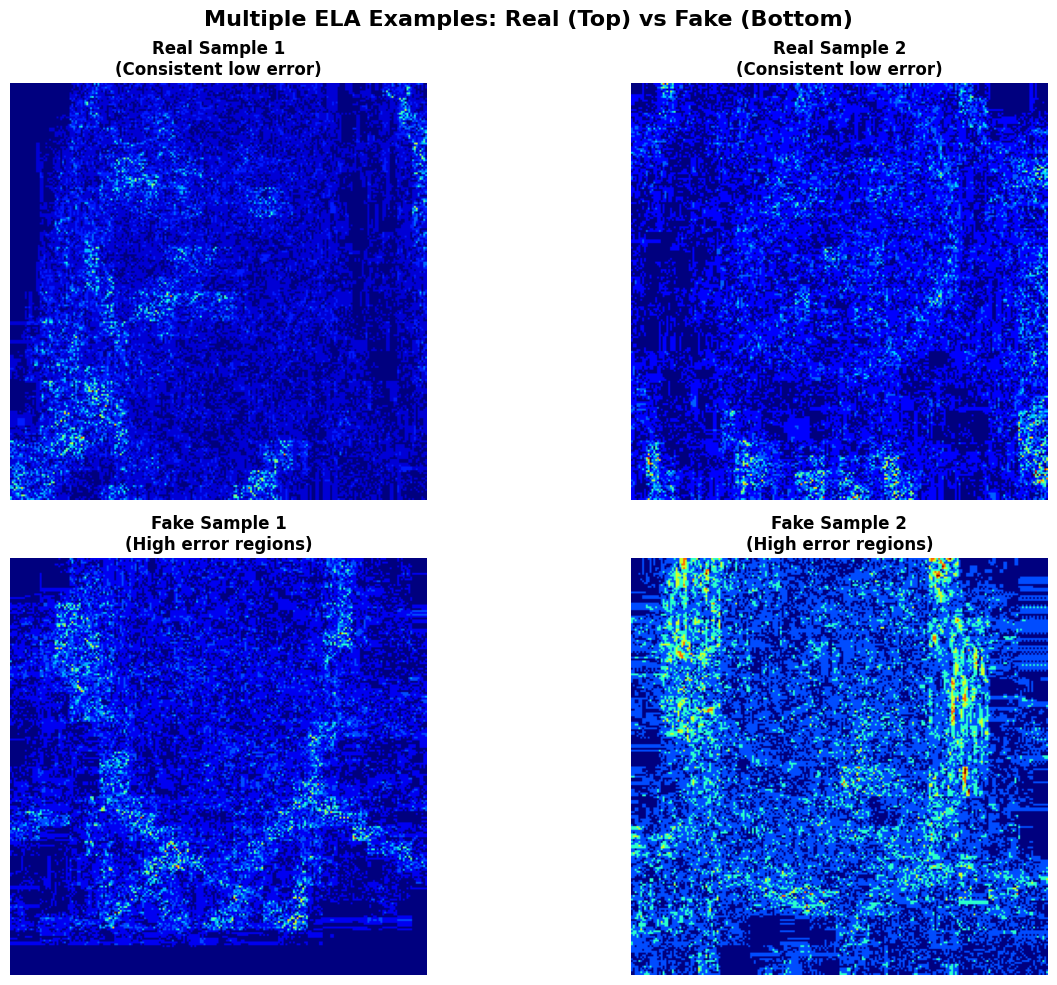

✓ Saved annotated version → /content/drive/MyDrive/FakeAVCeleb/poster_images/ela_annotated.png


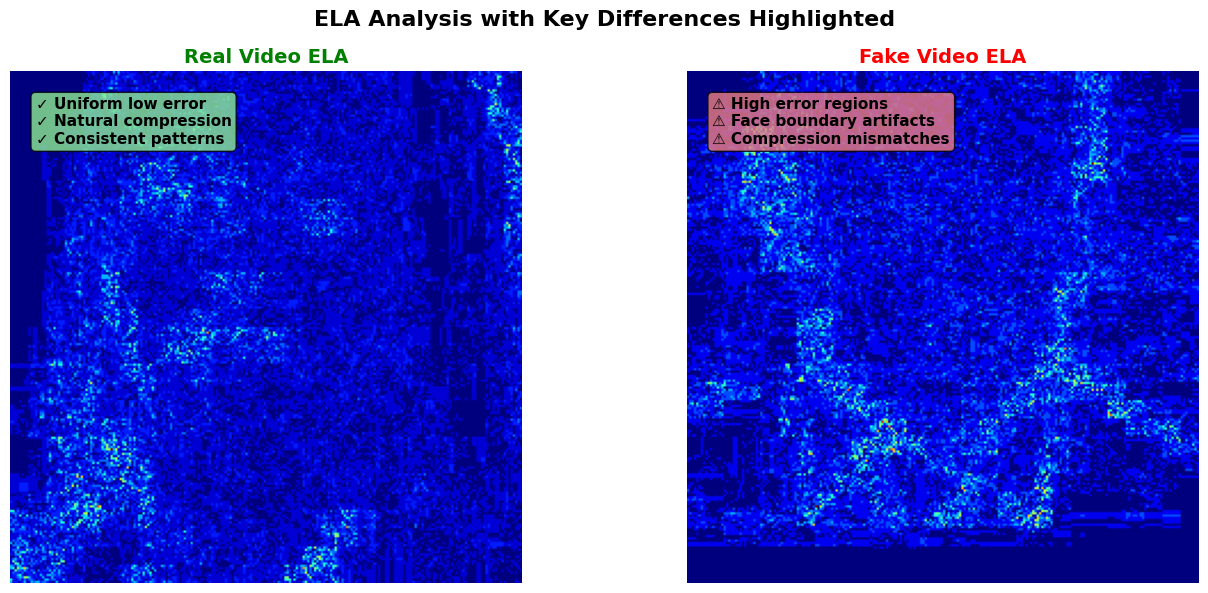


All ELA images saved to: /content/drive/MyDrive/FakeAVCeleb/poster_images

Generated files:
  1. ela_comparison_full.png (4-panel: original + ELA)
  2. ela_comparison_poster.png (simplified 2-panel) ⭐ BEST FOR POSTER
  3. ela_sidebyside.png (shows ELA transformation)
  4. ela_multiple_examples.png (2 real + 2 fake)
  5. ela_annotated.png (with key differences highlighted)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Generate Real vs Fake ELA Comparison Images for Poster
No training required - just visualization
"""

import io
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ===================== PATHS =====================
BASE_DIR = Path('/content/drive/MyDrive/FakeAVCeleb')
TEST_CSV = BASE_DIR / 'test_fixed_fullschema_hashsplit.csv'
RGB_DIR = BASE_DIR / 'frames'
OUTPUT_DIR = BASE_DIR / 'poster_images'

OUTPUT_DIR.mkdir(exist_ok=True)

# =================== ELA FUNCTION =================
def ela_from_rgb(pil_img: Image.Image, quality: int = 90) -> Image.Image:
    """Compute ELA image (grayscale) from an RGB PIL image."""
    pil_img = pil_img.convert("RGB")
    buf = io.BytesIO()
    pil_img.save(buf, "JPEG", quality=quality)
    buf.seek(0)
    jpg = Image.open(buf).convert("RGB")
    diff = ImageChops.difference(pil_img, jpg).convert("L")
    extrema = diff.getextrema()
    scale = 255.0 / max(1, extrema[1])
    diff = diff.point(lambda p: min(255, int(p * scale)))
    return diff

# =============== LOAD DATASET ====================
df = pd.read_csv(TEST_CSV)

# Get real and fake samples with enough frames
def get_valid_sample(df, label, min_frames=5):
    candidates = df[df['video_fake'] == label]
    for _, row in candidates.iterrows():
        sid = str(row['sample_id'])
        frames = sorted((RGB_DIR / sid).glob("frame_*.jpg"))
        if len(frames) >= min_frames:
            return sid, frames
    return None, None

print("Finding suitable samples...")
real_sid, real_frames = get_valid_sample(df, 0)
fake_sid, fake_frames = get_valid_sample(df, 1)

if real_sid is None or fake_sid is None:
    print(" Could not find suitable samples")
    exit()

print(f"Real sample: {real_sid} ({len(real_frames)} frames)")
print(f"Fake sample: {fake_sid} ({len(fake_frames)} frames)")

# Pick middle frame from each video
real_frame_path = real_frames[len(real_frames) // 2]
fake_frame_path = fake_frames[len(fake_frames) // 2]

# Load and process
real_rgb = Image.open(real_frame_path).convert("RGB")
fake_rgb = Image.open(fake_frame_path).convert("RGB")

real_ela = ela_from_rgb(real_rgb, quality=90)
fake_ela = ela_from_rgb(fake_rgb, quality=90)

print("\n✓ Generated ELA images")

# ============= CREATE MAIN VISUALIZATION ==============
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Error Level Analysis (ELA): Real vs Deepfake Detection',
             fontsize=18, fontweight='bold', y=0.96)

# Real original
axes[0, 0].imshow(real_rgb)
axes[0, 0].set_title('Real Video Frame\n(Original RGB)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Fake original
axes[0, 1].imshow(fake_rgb)
axes[0, 1].set_title('Fake Video Frame\n(Original RGB)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Real ELA
im1 = axes[1, 0].imshow(real_ela, cmap='jet', vmin=0, vmax=255)
axes[1, 0].set_title('Real ELA Map\n(Low uniform error - authentic)', fontsize=14, fontweight='bold', color='green')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04, label='Error Level')

# Fake ELA
im2 = axes[1, 1].imshow(fake_ela, cmap='jet', vmin=0, vmax=255)
axes[1, 1].set_title('Fake ELA Map\n(High error at face boundaries - manipulated)',
                     fontsize=14, fontweight='bold', color='red')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04, label='Error Level')

plt.tight_layout()

# Save full version
output_path_full = OUTPUT_DIR / 'ela_comparison_full.png'
plt.savefig(output_path_full, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved full comparison → {output_path_full}")

plt.show()

# ========== CREATE SIMPLIFIED POSTER VERSION ==========
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))
fig2.suptitle('ELA Preprocessing: Real vs Deepfake',
              fontsize=16, fontweight='bold', y=0.98)

# Real ELA
im1 = axes2[0].imshow(real_ela, cmap='jet', vmin=0, vmax=255)
axes2[0].set_title('Real Video\n(Uniform low error)', fontsize=13, fontweight='bold')
axes2[0].axis('off')

# Fake ELA
im2 = axes2[1].imshow(fake_ela, cmap='jet', vmin=0, vmax=255)
axes2[1].set_title('Fake Video\n(High error in manipulated regions)', fontsize=13, fontweight='bold')
axes2[1].axis('off')

# Shared colorbar
fig2.colorbar(im2, ax=axes2, fraction=0.046, pad=0.04, label='Compression Error Level')

# Add explanation text
fig2.text(0.5, 0.02,
          'ELA highlights compression inconsistencies: Real videos show uniform patterns (blue), '
          'while fake videos reveal artifacts at face boundaries (red/yellow)',
          ha='center', fontsize=10, style='italic', wrap=True)

plt.tight_layout()

# Save poster version
output_path_poster = OUTPUT_DIR / 'ela_comparison_poster.png'
plt.savefig(output_path_poster, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved poster version → {output_path_poster}")

plt.show()

# ========== CREATE SIDE-BY-SIDE ORIGINAL + ELA ==========
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 10))
fig3.suptitle('Visual Evidence of Deepfake Manipulation via ELA',
              fontsize=16, fontweight='bold')

# Top row: Real
axes3[0, 0].imshow(real_rgb)
axes3[0, 0].set_title('Real: Original Frame', fontsize=12, fontweight='bold')
axes3[0, 0].axis('off')

axes3[0, 1].imshow(real_ela, cmap='jet', vmin=0, vmax=255)
axes3[0, 1].set_title('Real: ELA Analysis', fontsize=12, fontweight='bold')
axes3[0, 1].axis('off')

# Bottom row: Fake
axes3[1, 0].imshow(fake_rgb)
axes3[1, 0].set_title('Fake: Original Frame', fontsize=12, fontweight='bold')
axes3[1, 0].axis('off')

axes3[1, 1].imshow(fake_ela, cmap='jet', vmin=0, vmax=255)
axes3[1, 1].set_title('Fake: ELA Analysis', fontsize=12, fontweight='bold')
axes3[1, 1].axis('off')

# Add arrows to show the transformation
arrow_props = dict(arrowstyle='->', lw=3, color='black')
fig3.text(0.35, 0.73, 'ELA →', fontsize=14, fontweight='bold', ha='center')
fig3.text(0.35, 0.27, 'ELA →', fontsize=14, fontweight='bold', ha='center')

plt.tight_layout()

output_path_sidebyside = OUTPUT_DIR / 'ela_sidebyside.png'
plt.savefig(output_path_sidebyside, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved side-by-side → {output_path_sidebyside}")

plt.show()

# ========== CREATE MULTIPLE EXAMPLES ==========
print("\n📊 Generating additional examples...")

# Get 2 more real and 2 more fake
real_samples = []
fake_samples = []

for _, row in df[df['video_fake'] == 0].iterrows():
    if len(real_samples) >= 2:
        break
    sid = str(row['sample_id'])
    frames = sorted((RGB_DIR / sid).glob("frame_*.jpg"))
    if len(frames) >= 3:
        real_samples.append((sid, frames))

for _, row in df[df['video_fake'] == 1].iterrows():
    if len(fake_samples) >= 2:
        break
    sid = str(row['sample_id'])
    frames = sorted((RGB_DIR / sid).glob("frame_*.jpg"))
    if len(frames) >= 3:
        fake_samples.append((sid, frames))

fig4, axes4 = plt.subplots(2, 2, figsize=(14, 10))
fig4.suptitle('Multiple ELA Examples: Real (Top) vs Fake (Bottom)',
              fontsize=16, fontweight='bold')

# Real samples
for idx, (sid, frames) in enumerate(real_samples):
    frame_path = frames[len(frames) // 2]
    rgb = Image.open(frame_path).convert("RGB")
    ela = ela_from_rgb(rgb, quality=90)

    axes4[0, idx].imshow(ela, cmap='jet', vmin=0, vmax=255)
    axes4[0, idx].set_title(f'Real Sample {idx+1}\n(Consistent low error)',
                           fontsize=12, fontweight='bold')
    axes4[0, idx].axis('off')

# Fake samples
for idx, (sid, frames) in enumerate(fake_samples):
    frame_path = frames[len(frames) // 2]
    rgb = Image.open(frame_path).convert("RGB")
    ela = ela_from_rgb(rgb, quality=90)

    axes4[1, idx].imshow(ela, cmap='jet', vmin=0, vmax=255)
    axes4[1, idx].set_title(f'Fake Sample {idx+1}\n(High error regions)',
                           fontsize=12, fontweight='bold')
    axes4[1, idx].axis('off')

plt.tight_layout()

output_path_multi = OUTPUT_DIR / 'ela_multiple_examples.png'
plt.savefig(output_path_multi, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved multiple examples → {output_path_multi}")

plt.show()

# ========== CREATE ANNOTATED VERSION ==========
fig5, axes5 = plt.subplots(1, 2, figsize=(14, 6))
fig5.suptitle('ELA Analysis with Key Differences Highlighted',
              fontsize=16, fontweight='bold')

# Real ELA with annotation
axes5[0].imshow(real_ela, cmap='jet', vmin=0, vmax=255)
axes5[0].set_title('Real Video ELA', fontsize=14, fontweight='bold', color='green')
axes5[0].axis('off')
axes5[0].text(0.05, 0.95, '✓ Uniform low error\n✓ Natural compression\n✓ Consistent patterns',
             transform=axes5[0].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
             fontweight='bold')

# Fake ELA with annotation
axes5[1].imshow(fake_ela, cmap='jet', vmin=0, vmax=255)
axes5[1].set_title('Fake Video ELA', fontsize=14, fontweight='bold', color='red')
axes5[1].axis('off')
axes5[1].text(0.05, 0.95, '⚠ High error regions\n⚠ Face boundary artifacts\n⚠ Compression mismatches',
             transform=axes5[1].transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
             fontweight='bold')

plt.tight_layout()

output_path_annotated = OUTPUT_DIR / 'ela_annotated.png'
plt.savefig(output_path_annotated, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved annotated version → {output_path_annotated}")

plt.show()

print(f"\nAll ELA images saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
print("  1. ela_comparison_full.png (4-panel: original + ELA)")
print("  2. ela_comparison_poster.png (simplified 2-panel) ⭐ BEST FOR POSTER")
print("  3. ela_sidebyside.png (shows ELA transformation)")
print("  4. ela_multiple_examples.png (2 real + 2 fake)")
print("  5. ela_annotated.png (with key differences highlighted)")

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ELA ResNet18 — video-level, with optional ON-THE-FLY ELA from RGB
- Choice: use precomputed frames_ela/ OR compute ELA from frames/ at load time
- K-frame averaging (train/eval), class weights, early stopping
- Saves best weights, full model, embeddings, and index CSV to Drive
"""

import io, random, gc
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageChops
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# ======================
# CONFIG
# ======================
class CFG:
    BASE      = Path("/content/drive/MyDrive/FakeAVCeleb")   # root folder in Drive
    ELA_DIR   = BASE/"frames_ela"
    RGB_DIR   = BASE/"frames"
    TRAIN_CSV = BASE/"train_fixed_fullschema_hashsplit.csv"
    TEST_CSV  = BASE/"test_fixed_fullschema_hashsplit.csv"

    USE_ELA_ON_THE_FLY = True

    IMG_SIZE = 224
    K_TRAIN = 4
    K_EVAL  = 7
    SKIP_EDGE_FRAC = 0.10

    BATCH_SIZE = 8
    EPOCHS = 10
    LR = 1e-4
    WD = 1e-4
    PATIENCE = 3

    NUM_WORKERS = 0
    PIN_MEMORY = False

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 1337

    # --- save paths (all in Drive) ---
    SAVE       = str(BASE/"resnet18_ela_video_best.pth")   # best weights (state_dict)
    FULL_MODEL = str(BASE/"resnet18_ela_video_full.pth")   # full model
    EMB_DIR    = BASE/"fusion_video_emb"                   # embeddings folder
    INDEX_CSV  = BASE/"fusion_video_index.csv"             # index file

def set_seed(s):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(CFG.SEED)
torch.set_num_threads(2)

# ======================
# ELA utils (on-the-fly)
# ======================
def ela_from_rgb(pil_img: Image.Image, quality: int = 90) -> Image.Image:
    """Compute ELA image (grayscale) from an RGB PIL image."""
    pil_img = pil_img.convert("RGB")
    buf = io.BytesIO()
    pil_img.save(buf, "JPEG", quality=quality)
    buf.seek(0)
    jpg = Image.open(buf).convert("RGB")
    diff = ImageChops.difference(pil_img, jpg).convert("L")
    extrema = diff.getextrema()
    scale = 255.0 / max(1, extrema[1])
    diff = diff.point(lambda p: min(255, int(p * scale)))
    return diff

# ======================
# TRANSFORMS
# ======================
IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]

def make_transform(train: bool):
    ops = [transforms.Grayscale(num_output_channels=3),
           transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE))]
    if train: ops += [transforms.RandomHorizontalFlip()]
    ops += [transforms.ToTensor(),
            transforms.Normalize(IMNET_MEAN, IMNET_STD)]
    return transforms.Compose(ops)

# ======================
# DATASET
# ======================
class ELAVideoDataset(Dataset):
    def __init__(self, df, train: bool):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.tf = make_transform(train)
        self.items = []
        dropped = 0
        for _, row in self.df.iterrows():
            sid = str(row["sample_id"]); y = int(row["video_fake"])
            root = CFG.RGB_DIR if CFG.USE_ELA_ON_THE_FLY else CFG.ELA_DIR
            frames = sorted((root/sid).glob("frame_*.jpg"))
            if len(frames) >= 2:
                self.items.append((sid, y, [str(p) for p in frames]))
            else:
                dropped += 1
        print(f"[ELA{'*' if CFG.USE_ELA_ON_THE_FLY else ''}/"
              f"{'train' if train else 'eval'}] kept {len(self.items)}, dropped {dropped}")

    def __len__(self): return len(self.items)

    def _pick_train(self, n, k):
        a0 = int(CFG.SKIP_EDGE_FRAC*n); a1 = int((1-CFG.SKIP_EDGE_FRAC)*n)
        a1 = max(a1, a0+1)
        edges = np.linspace(a0, a1, k+1, dtype=int)
        return [random.randint(edges[i], max(edges[i+1]-1, edges[i])) for i in range(k)]

    def _pick_eval(self, n, k):
        if k == 1: return [n//2]
        return [int(round(i*(n-1)/(k-1))) for i in range(k)]

    def __getitem__(self, idx):
        sid, y, frames = self.items[idx]
        n = len(frames)
        K = CFG.K_TRAIN if self.train else CFG.K_EVAL
        picks = self._pick_train(n, K) if self.train else self._pick_eval(n, K)

        imgs = []
        for p in picks:
            with Image.open(frames[p]) as rgb_im:
                if CFG.USE_ELA_ON_THE_FLY:
                    ela_im = ela_from_rgb(rgb_im, quality=90)
                else:
                    ela_im = rgb_im.convert("L")
                imgs.append(self.tf(ela_im))
        x = torch.stack(imgs, 0)  # [K,3,H,W]
        return x, y, sid

# ======================
# MODEL
# ======================
class VideoWrap(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, xk):
        B, K, C, H, W = xk.shape
        x = xk.view(B*K, C, H, W)
        logits = self.base(x)
        return logits.view(B, K, -1).mean(1)

def build_model():
    net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_feats = net.fc.in_features
    net.fc = nn.Linear(in_feats, 2)
    return VideoWrap(net)

# ======================
# TRAIN / EVAL
# ======================
def class_weights_from(y):
    w = compute_class_weight("balanced", classes=np.array([0,1]), y=y)
    return torch.tensor(w, dtype=torch.float, device=CFG.DEVICE)

def make_loaders(train_df, val_df):
    tr_ds = ELAVideoDataset(train_df, train=True)
    va_ds = ELAVideoDataset(val_df,   train=False)
    tr_dl = DataLoader(tr_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,
                       num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY)
    va_dl = DataLoader(va_ds, batch_size=CFG.BATCH_SIZE, shuffle=False,
                       num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY)
    return tr_dl, va_dl

def train_one_epoch(model, dl, loss_fn, opt):
    model.train()
    run = 0.0; correct = 0; n_items = 0
    for xb, yb, _ in tqdm(dl, leave=False):
        xb = xb.to(CFG.DEVICE, non_blocking=True)
        yb = torch.as_tensor(yb, device=CFG.DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward(); opt.step()
        run += float(loss.item())
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        n_items += yb.numel()
        del xb, yb, logits, loss
        if CFG.DEVICE == "cpu": gc.collect()
    return run/len(dl), correct/max(1, n_items)

@torch.no_grad()
def evaluate(model, dl, return_probs=False):
    model.eval(); soft = nn.Softmax(dim=1)
    preds, trues, sids, probs = [], [], [], []
    for xb, yb, sid in dl:
        xb = xb.to(CFG.DEVICE, non_blocking=True)
        logits = model(xb)
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p.tolist())
        trues.extend(torch.as_tensor(yb).cpu().tolist())
        sids.extend(list(sid))
        if return_probs:
            probs.extend(soft(logits)[:,1].cpu().numpy().tolist())
    trues = np.array(trues); preds = np.array(preds)
    acc = (trues == preds).mean()
    return (acc, trues, preds, sids, np.array(probs)) if return_probs else (acc, trues, preds)

# ======================
# MAIN
# ======================
def main():
    print("Loading splits...")
    df_train_full = pd.read_csv(CFG.TRAIN_CSV)[["sample_id","video_fake"]].copy()
    df_test       = pd.read_csv(CFG.TEST_CSV)[["sample_id","video_fake"]].copy()
    df_train_full["video_fake"] = df_train_full["video_fake"].astype(int)
    df_test["video_fake"]       = df_test["video_fake"].astype(int)

    train_df, val_df = train_test_split(df_train_full, test_size=0.1,
                                        stratify=df_train_full["video_fake"], random_state=CFG.SEED)
    print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(df_test)}")
    tr_dl, va_dl = make_loaders(train_df, val_df)

    model = build_model().to(CFG.DEVICE)
    cls_w = class_weights_from(train_df["video_fake"].values)
    loss_fn = nn.CrossEntropyLoss(weight=cls_w)
    opt = torch.optim.Adam(model.parameters(), lr=CFG.LR, weight_decay=CFG.WD)

    best, bad = 0.0, 0
    for epoch in range(1, CFG.EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, tr_dl, loss_fn, opt)
        va_acc, _, _ = evaluate(model, va_dl)
        print(f"Epoch {epoch:02d} | TrainLoss {tr_loss:.4f} | TrainAcc {tr_acc:.4f} | ValAcc {va_acc:.4f}")
        if va_acc > best:
            best, bad = va_acc, 0
            torch.save(model.state_dict(), CFG.SAVE)
            print(f"  ✓ New best ({best:.4f})")
        else:
            bad += 1
            if bad >= CFG.PATIENCE: break

    # ===== TEST =====
    print("\nEvaluating on TEST...")
    te_ds = ELAVideoDataset(df_test, train=False)
    te_dl = DataLoader(te_ds, batch_size=CFG.BATCH_SIZE, shuffle=False,
                       num_workers=CFG.NUM_WORKERS, pin_memory=CFG.PIN_MEMORY)
    state = torch.load(CFG.SAVE, map_location=CFG.DEVICE)
    model.load_state_dict(state); model.to(CFG.DEVICE)
    te_acc, y_true, y_pred, te_sids, te_probs = evaluate(model, te_dl, return_probs=True)
    print(f"TEST Acc (video): {te_acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Real","Fake"]))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # ===== SAVE FULL MODEL =====
    torch.save(model, CFG.FULL_MODEL)
    print(f"Saved full model → {CFG.FULL_MODEL}")

    # ===== EXPORT EMBEDDINGS =====
    EMB_DIR, INDEX_CSV = CFG.EMB_DIR, CFG.INDEX_CSV
    EMB_DIR.mkdir(parents=True, exist_ok=True)

    class ResnetFeatureExtractor(nn.Module):
        def __init__(self, model):
            super().__init__(); self.base = model.base
            self.feature_extractor = nn.Sequential(*list(self.base.children())[:-1])
        def forward(self, xk):
            B,K,C,H,W = xk.shape
            x = xk.view(B*K, C, H, W)
            feats = self.feature_extractor(x)      # [B*K,512,1,1]
            feats = feats.view(B, K, -1)
            return feats.mean(1)                   # [B,512]

    feat_model = ResnetFeatureExtractor(model).to(CFG.DEVICE); feat_model.eval()
    all_rows = []

    # export test
    with torch.no_grad():
        for xb,yb,sids in tqdm(te_dl, desc="Export test emb"):
            xb = xb.to(CFG.DEVICE)
            emb = feat_model(xb).cpu().numpy()
            for sid,e,lbl in zip(sids, emb, yb.numpy().astype(int)):
                path = EMB_DIR/f"{sid}_vid512.npy"
                np.save(path, e.astype(np.float32))
                all_rows.append({"sample_id": sid, "video_emb_path": str(path),
                                 "label": int(lbl), "split": "test"})

    # export train+val
    trval_ds = ELAVideoDataset(train_df.append(val_df), train=False)
    trval_dl = DataLoader(trval_ds, batch_size=CFG.BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for xb,yb,sids in tqdm(trval_dl, desc="Export train/val emb"):
            xb = xb.to(CFG.DEVICE)
            emb = feat_model(xb).cpu().numpy()
            for sid,e,lbl in zip(sids, emb, yb.numpy().astype(int)):
                path = EMB_DIR/f"{sid}_vid512.npy"
                np.save(path, e.astype(np.float32))
                all_rows.append({"sample_id": sid, "video_emb_path": str(path),
                                 "label": int(lbl), "split": "train"})

    pd.DataFrame(all_rows).to_csv(INDEX_CSV, index=False)
    print(f"Saved video embeddings → {INDEX_CSV} ({len(all_rows)} rows)")

if __name__ == "__main__":
    main()


Loading splits...
Train: 1433 | Val: 160 | Test: 407
[ELA*/train] kept 1433, dropped 0
[ELA*/eval] kept 160, dropped 0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 81.4MB/s]


Epoch 01 | TrainLoss 0.3226 | TrainAcc 0.8590 | ValAcc 0.9187
  ✓ New best (0.9187)


Epoch 02 | TrainLoss 0.2491 | TrainAcc 0.9058 | ValAcc 0.8875


Epoch 03 | TrainLoss 0.2236 | TrainAcc 0.9239 | ValAcc 0.9187


Epoch 04 | TrainLoss 0.1647 | TrainAcc 0.9477 | ValAcc 0.8750

Evaluating on TEST...
[ELA*/eval] kept 407, dropped 0
TEST Acc (video): 0.9287

Classification Report:
               precision    recall  f1-score   support

        Real       0.88      0.98      0.93       200
        Fake       0.98      0.87      0.93       207

    accuracy                           0.93       407
   macro avg       0.93      0.93      0.93       407
weighted avg       0.93      0.93      0.93       407

Confusion Matrix:
 [[197   3]
 [ 26 181]]
Saved full model → /content/drive/MyDrive/FakeAVCeleb/resnet18_ela_video_full.pth


Export test emb: 100%|██████████| 51/51 [04:47<00:00,  5.64s/it]


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
import io
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageChops
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms

# ======================
# CONFIG
# ======================
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BASE       = Path("/content/drive/MyDrive/FakeAVCeleb")
MODEL_PATH = BASE/"resnet18_ela_video_full.pth"
TRAIN_CSV  = BASE/"train_fixed_fullschema_hashsplit.csv"
TEST_CSV   = BASE/"test_fixed_fullschema_hashsplit.csv"
RGB_DIR    = BASE/"frames"
OUT_DIR    = BASE/"fusion_video_emb"
OUT_CSV    = BASE/"fusion_video_emb_index.csv"
OUT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE   = 224
K_EVAL     = 7   # frames per clip

# ======================
# UTILS: ELA transform
# ======================
def ela_from_rgb(pil_img: Image.Image, quality: int = 90) -> Image.Image:
    pil_img = pil_img.convert("RGB")
    buf = io.BytesIO()
    pil_img.save(buf, "JPEG", quality=quality)
    buf.seek(0)
    jpg = Image.open(buf).convert("RGB")
    diff = ImageChops.difference(pil_img, jpg).convert("L")
    extrema = diff.getextrema()
    scale = 255.0 / max(1, extrema[1])
    diff = diff.point(lambda p: min(255, int(p * scale)))
    return diff

IMNET_MEAN = [0.485, 0.456, 0.406]
IMNET_STD  = [0.229, 0.224, 0.225]
TFM = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

# ======================
# Try loading model
# ======================
def build_model():
    net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_feats = net.fc.in_features
    net.fc = nn.Linear(in_feats, 2)  # 2 classes: Real/Fake
    return VideoWrap(net)

class VideoWrap(nn.Module):
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, xk):
        B,K,C,H,W = xk.shape
        x = xk.view(B*K, C, H, W)
        logits = self.base(x)
        return logits.view(B, K, -1).mean(1)

try:
    model_full = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
    print("✓ Loaded full pickled model")
except Exception:
    print("⚠️  Could not unpickle full model, trying state_dict...")
    model_full = build_model()
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    model_full.load_state_dict(state_dict)
    print("✓ Loaded from state_dict")

model_full.to(DEVICE).eval()

# ======================
# Feature extractor
# ======================
class ResnetFeatureExtractor(nn.Module):
    """Take VideoWrap(base), remove FC, return 512-D pooled features."""
    def __init__(self, model):
        super().__init__()
        self.base = model.base
        self.feature_extractor = nn.Sequential(*list(self.base.children())[:-1])
    def forward(self, xk):
        B,K,C,H,W = xk.shape
        x = xk.view(B*K, C, H, W)
        feats = self.feature_extractor(x)  # [B*K,512,1,1]
        feats = feats.view(B, K, -1)
        return feats.mean(1)               # [B,512]

feat_model = ResnetFeatureExtractor(model_full).to(DEVICE).eval()

# ======================
# Export helper
# ======================
def export_split(df: pd.DataFrame, split_name: str):
    rows = []
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Export {split_name} emb"):
            sid = str(row['sample_id']); y = int(row['video_fake'])
            frames = sorted((RGB_DIR/sid).glob("frame_*.jpg"))
            if len(frames) < K_EVAL: continue
            picks = np.linspace(0, len(frames)-1, K_EVAL, dtype=int)

            imgs = []
            for p in picks:
                with Image.open(frames[p]) as rgb_im:
                    ela_im = ela_from_rgb(rgb_im, quality=90)
                    imgs.append(TFM(ela_im))
            xb = torch.stack(imgs, 0).unsqueeze(0).to(DEVICE)  # [1,K,3,H,W]

            emb = feat_model(xb).squeeze(0).cpu().numpy()      # [512]
            path = OUT_DIR / f"{sid}_vid512.npy"
            np.save(path, emb.astype(np.float32))

            rows.append({"sample_id": sid,
                         "video_emb_path": str(path),
                         "label": y,
                         "split": split_name})
    return rows

# ======================
# Run export
# ======================
train_df = pd.read_csv(TRAIN_CSV)[["sample_id","video_fake"]]
test_df  = pd.read_csv(TEST_CSV)[["sample_id","video_fake"]]

all_rows = []
all_rows += export_split(train_df, "train")
all_rows += export_split(test_df, "test")

pd.DataFrame(all_rows).to_csv(OUT_CSV, index=False)
print(f"✓ Saved {len(all_rows)} embeddings → {OUT_CSV}")


✓ Loaded full pickled model


Export test emb: 100%|██████████| 407/407 [09:48<00:00,  1.45s/it]

✓ Saved 2000 embeddings → /content/drive/MyDrive/FakeAVCeleb/fusion_video_emb_index.csv
